In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

#グローバル変数
target_col = "Survived"
FIG_SERIAL_NUM = 1 # 表、グラフ等の図のシリアル番号

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [2]:
cols = train.columns
cols
#type(cols) #Index

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
dic = {
    "PassengerId":"乗客のユニークID ",
    "Survived":"乗客の生死. 0 = 死亡, 1 = 生存",
    "Pclass":"チケットのクラス. 1等席~3等席",
    "Name":"乗客名",
    "Sex":"性別.male or female",
    "Age":"年齢",
    "SibSp":"同乗の兄弟姉妹、配偶者の人数",
    "Parch":"同乗の親、子供の人数",
    "Ticket":"チケット番号",
    "Fare":"乗船料",
    "Cabin":"キャビン番号",
    "Embarked":"乗客が乗船した港."
}

dic
                 

{'PassengerId': '乗客のユニークID ',
 'Survived': '乗客の生死. 0 = 死亡, 1 = 生存',
 'Pclass': 'チケットのクラス. 1等席~3等席',
 'Name': '乗客名',
 'Sex': '性別.male or female',
 'Age': '年齢',
 'SibSp': '同乗の兄弟姉妹、配偶者の人数',
 'Parch': '同乗の親、子供の人数',
 'Ticket': 'チケット番号',
 'Fare': '乗船料',
 'Cabin': 'キャビン番号',
 'Embarked': '乗客が乗船した港.'}

In [4]:
#レコード数
#欠損率
#ユニーク数
#type(df.info())はNoneType
#type(df.dtypes)はSeries

def iput_data_summary (data_df, header_info_dic, output_data_head_fname = "data_head.csv",output_col_info_fname = "col_info.csv",f_encode = "utf-8"):
    col_info_df = pd.DataFrame(dic.values(),index=dic.keys())
    col_info_df = col_info_df.rename(columns={0: 'カラム概要'})
    
    total_record_count = data_df.shape[0]
    
    unique_num_list = []
    null_record_count_list = []
    loss_data_rate_list = []
    for index, row in col_info_df.iterrows():
        #print(index)
        unique_num_list.append(data_df[index].unique().size)
        null_record_count = data_df[index].isnull().sum()
        null_record_count_list.append(null_record_count)
        loss_data_rate_list.append(round((null_record_count / total_record_count),3) ) 
    
    col_info_df["レコード数"] = total_record_count
    col_info_df["ユニーク数"] = unique_num_list
    col_info_df["欠損(null)数"] = null_record_count_list
    col_info_df["欠損率"] = loss_data_rate_list
    col_info_df["データ型"] = data_df.dtypes
    
    data_df.head(3).to_csv(output_data_head_fname, index=False,encoding=f_encode)
    
    col_info_df.reset_index(inplace= True)
    col_info_df = col_info_df.rename(columns={'index': 'カラム名'})
    col_info_df.to_csv(output_col_info_fname, index=False,encoding=f_encode)
    #print(col_info_df)
    return col_info_df
    

In [5]:
col_info_summary = iput_data_summary(data_df=train, header_info_dic=dic)

col_info_summary

,カラム名,カラム概要,レコード数,ユニーク数,欠損(null)数,欠損率,データ型
0,PassengerId,乗客のユニークID,891,891,0,0.000,int64
1,Survived,"乗客の生死. 0 = 死亡, 1 = 生存",891,2,0,0.000,int64
2,Pclass,チケットのクラス. 1等席~3等席,891,3,0,0.000,int64
3,Name,乗客名,891,891,0,0.000,object
4,Sex,性別.male or female,891,2,0,0.000,object
5,Age,年齢,891,89,177,0.199,float64
6,SibSp,同乗の兄弟姉妹、配偶者の人数,891,7,0,0.000,int64
7,Parch,同乗の親、子供の人数,891,7,0,0.000,int64
8,Ticket,チケット番号,891,681,0,0.000,object
9,Fare,乗船料,891,248,0,0.000,float64


https://baseball-y-programming.com/python-csv-powerpoint/


https://hk29.hatenablog.jp/entry/2020/10/03/234420

https://blog2.k05.biz/2021/02/python-pptx.html

In [8]:
!pip install python-pptx

#PowerPointを編集するためのライブラリ
from pptx import Presentation

#サイズやテキストを扱うためのライブラリ
from pptx.util import Inches, Pt
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 17.7 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 11.8 MB/s eta 0:00:00
  Created wheel for python-pptx: filename=python_pptx-0.6.21-py3-none-any.whl size=470951 sha256=6988e292122cd1a94f4a8481b7e14632be370cffc7f716ceaae0b31acb108fba
  Stored in directory: /root/.cache/pip/wheels/a7/ab/f4/52560d0d4bd4055e9261c6df6e51c7b56c2b23cca3dee811a3
Successfully built python-pptx


In [9]:
###1枚目のスライドを作成###
prs = Presentation()

#PowerPointのスライドのレイアウトを決める
title_slide_layout = prs.slide_layouts[1]

#レイアウトを適用する
slide = prs.slides.add_slide(title_slide_layout)

#スライドのタイトルを用意
title = slide.shapes.title

#タイトルに書き込む
title.text = "データ概要"

#PowerPointにCSVファイルのデータを入れるためには，
#数値型（intやfloat）ではなく，文字型（str）に変換する必要があります．
corona = pd.read_csv("col_info.csv").astype("str")

#コラムのみをリスト化
corona_col = list([corona.columns.tolist()])

#表示
corona_col


[['カラム名', 'カラム概要', 'レコード数', 'ユニーク数', '欠損(null)数', '欠損率', 'データ型']]

In [11]:
#インチをセンチメートルに変換する
def Centis(length):
    
    centi = Inches(length/2.54)
    
    return centi

#リスト化（コラムと数値を合わせる）
corona_list = corona_col+ corona.values.tolist()

#表示
corona_list

[['カラム名', 'カラム概要', 'レコード数', 'ユニーク数', '欠損(null)数', '欠損率', 'データ型'],
 ['PassengerId', '乗客のユニークID ', '891', '891', '0', '0.0', 'int64'],
 ['Survived', '乗客の生死. 0 = 死亡, 1 = 生存', '891', '2', '0', '0.0', 'int64'],
 ['Pclass', 'チケットのクラス. 1等席~3等席', '891', '3', '0', '0.0', 'int64'],
 ['Name', '乗客名', '891', '891', '0', '0.0', 'object'],
 ['Sex', '性別.male or female', '891', '2', '0', '0.0', 'object'],
 ['Age', '年齢', '891', '89', '177', '0.199', 'float64'],
 ['SibSp', '同乗の兄弟姉妹、配偶者の人数', '891', '7', '0', '0.0', 'int64'],
 ['Parch', '同乗の親、子供の人数', '891', '7', '0', '0.0', 'int64'],
 ['Ticket', 'チケット番号', '891', '681', '0', '0.0', 'object'],
 ['Fare', '乗船料', '891', '248', '0', '0.0', 'float64'],
 ['Cabin', 'キャビン番号', '891', '148', '687', '0.771', 'object'],
 ['Embarked', '乗客が乗船した港.', '891', '4', '2', '0.002', 'object']]

In [12]:
#cell内のフォントサイズ
cell_font = 11

#挿入する位置
table_left = Centis(6)

table_top = Centis(12)

#tableの幅と高さ
table_width = Centis(18)

table_height = Centis(8)

#tableの行数と列名
table_row = len(corona_list)

table_col = len(corona_list[0])

table = slide.shapes.add_table(table_row, 
                              table_col, 
                              table_left, 
                              table_top,
                              table_width, 
                              table_height).table

#表の各セルに文字や数値を記入
for i in range(table_row):
    
    for j in range(table_col):
        
        #セルを用意
        cell = table.cell(i, j)
        
        #セル内に入れていく
        cell.text = corona_list[i][j]
        
        #フォントサイズを適用
        cell.text_frame.paragraphs[0].font.size = Pt(cell_font)

In [14]:
#表にタイトルを付ける
#テキストボックスを用意
img_text1 = "表1 データ概要"

#テキストボックスの位置
text1_left = Centis(15)

text1_top = Centis(5)

#テキストボックスの幅と高さを決める
text1_width = Centis(8)

text1_height = Centis(1)

#文字のフォントサイズを決める
textbox1_fontsize = 11

textbox1 = slide.shapes.add_textbox(text1_left,
                                  text1_top,
                                  text1_width,
                                  text1_height)

#テキストを書きこむ
textbox1.text = img_text1

#フォントサイズを適用
textbox1.text_frame.add_paragraph().font.size = Pt(textbox1_fontsize)

#セーブファイル名
prs.save("Coronavirus.pptx")

In [15]:
#数値型（intやfloat）ではなく，文字型（str）に変換する必要があります．
df = pd.read_csv("data_head.csv").astype("str")

#コラムのみをリスト化
data_head_list = list([df.columns.tolist()])
#リスト化（コラムと数値を合わせる）
data_head_list = data_head_list+ df.values.tolist()

###1枚目のスライドを作成###
prs = Presentation()

#PowerPointのスライドのレイアウトを決める
title_slide_layout = prs.slide_layouts[1]

#レイアウトを適用する
slide = prs.slides.add_slide(title_slide_layout)

#スライドのタイトルを用意
title = slide.shapes.title

#タイトルに書き込む
title.text = "データサンプル"

table_row = len(data_head_list)

table_col = len(data_head_list[0])

table = slide.shapes.add_table(table_row, 
                              table_col, 
                              table_left, 
                              table_top,
                              table_width, 
                              table_height).table

#テキストボックスの幅と高さを決める
text1_width = Centis(20)

text1_height = Centis(7)

#表の各セルに文字や数値を記入
for i in range(table_row):
    
    for j in range(table_col):
        
        #セルを用意
        cell = table.cell(i, j)
        
        #セル内に入れていく
        cell.text = data_head_list[i][j]
        
        #フォントサイズを適用
        cell.text_frame.paragraphs[0].font.size = Pt(cell_font)
    

#テキストボックスを用意
img_text1 = "データサンプル"

#テキストボックスの位置
text1_left = Centis(10)

text1_top = Centis(10)

textbox1 = slide.shapes.add_textbox(text1_left,
                                  text1_top,
                                  text1_width,
                                  text1_height)

#テキストを書きこむ
textbox1.text = img_text1

#フォントサイズを適用
textbox1.text_frame.add_paragraph().font.size = Pt(textbox1_fontsize)

#セーブファイル名
prs.save("data_sample.pptx")

# オーソドックスなEDA手法

- 1.ヒストグラム(分布)
- 2.棒グラフ(差や大小関係)
- 3.箱ひげ図(外れ値)
- 4.折れ線グラフ(推移)
- 5.散布図(2変数間の相関、分布、外れ値)
- 6.ヒートマップ(多変数間の相関)



# クリーニング

- 1.欠損値
- 2.外れ値
- 3.表記ゆれ
- 4.データ重複
- 5.データ変換(型や、意味変換。0=>生存。1=>死亡, 尺度変換、無名数化)

>ex.) 尺度変換：比例尺度→順序尺度 ... 支払い金額を会員ランク(low, nomarl, high)にする


# 1変数

- hist (分布、正規分布?)
- 箱ひげ図 (外れ値)

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.astype("str").describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,891,891,891,891,891,891,891,891,891
unique,891,2,3,891,2,89,7,7,681,248,148,4
top,1,0,3,"Braund, Mr. Owen Harris",male,nan,0,0,347082,8.05,nan,S
freq,1,549,491,1,577,177,608,678,7,43,687,644


In [163]:
def print_pie_graph(df, target_column):
    labels = df[target_column].value_counts(ascending=False, normalize=False).index
    vals = df[target_column].value_counts(ascending=False, normalize=False).values

    print("labels:",labels)
    plt.title(target_column)
    plt.axis("equal")
    plt.legend()

    plt.pie(vals,labels=labels,autopct="%1.1f%%",startangle=90,counterclock=False)
    fname=target_column+"_pie_graph"+".png"
    plt.tight_layout()
    plt.savefig(fname=fname) # 画像を保存する場合
    plt.show()
    

labels: Int64Index([0, 1], dtype='int64')


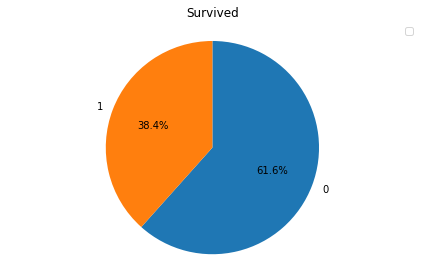

In [164]:
target_column = "Survived"
#目的変数の分布・割合
print_pie_graph(train,target_column)

### 1変数(質的データ)

In [ ]:
train['Survived'] = train['Survived'].astype('str')
print(train.dtypes)

In [233]:
str_col = col_info_summary[col_info_summary["データ型"]=="object"]
str_col_series = str_col["カラム名"]
str_col_series

3         Name
4          Sex
8       Ticket
10       Cabin
11    Embarked
12        Deck
Name: カラム名, dtype: object

Name


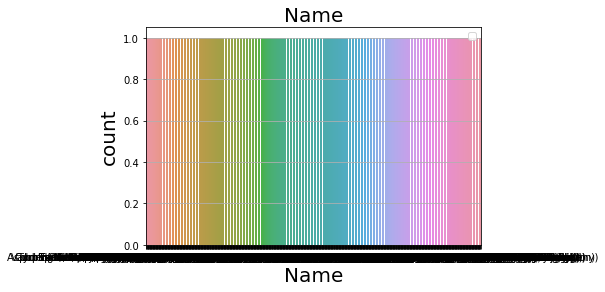

Sex


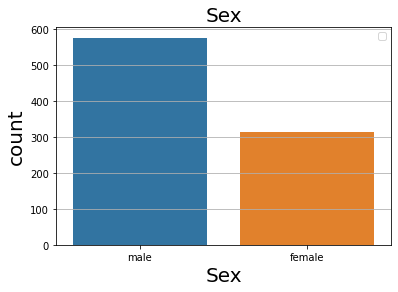

Ticket


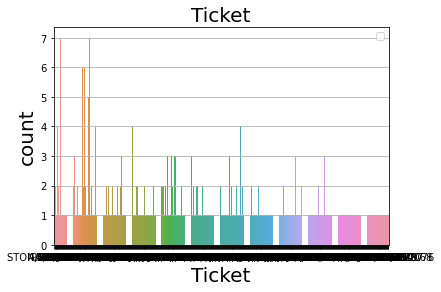

Cabin


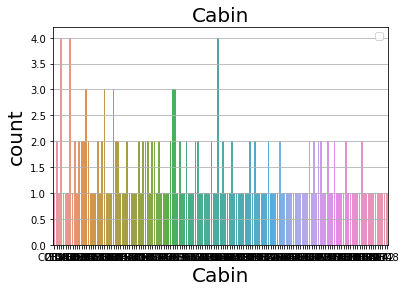

Embarked


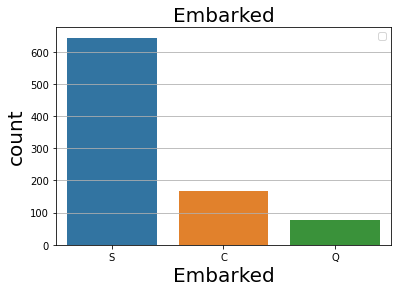

In [188]:
for col in str_col_series:
    print(col)
    title = "1variable_category_"+col+"_hist"
    fname=title+".png"
    plt.xlabel(col, fontsize=20) #x軸ラベル
    plt.ylabel("Frequency", fontsize=20)#y軸ラベル
    plt.grid(True)      # 目盛線の表示
    #plt.title(col, fontsize=20)  # タイトル
    plt.legend()
    sns.countplot(col,data=train)
    plt.savefig(fname)
    plt.show()
    

### 1変数(量的データ)

In [182]:
numerical_col = col_info_summary[col_info_summary["データ型"]!="object"]
numerical_col_series = numerical_col["カラム名"]
numerical_col_series

0    PassengerId
1       Survived
2         Pclass
5            Age
6          SibSp
7          Parch
9           Fare
Name: カラム名, dtype: object

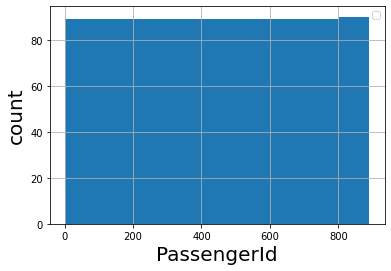

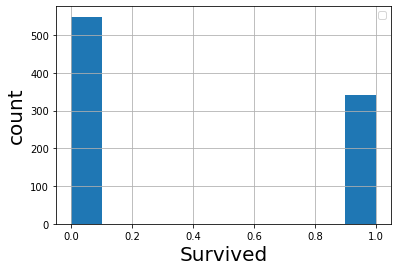

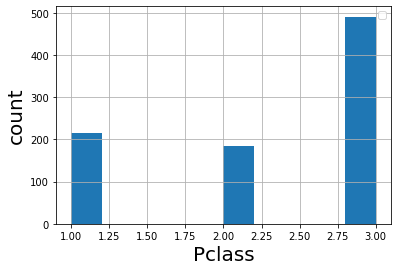

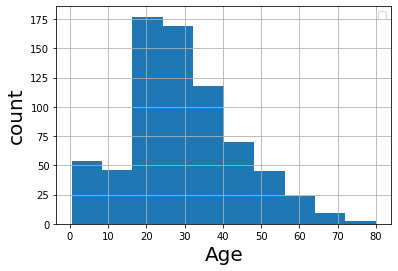

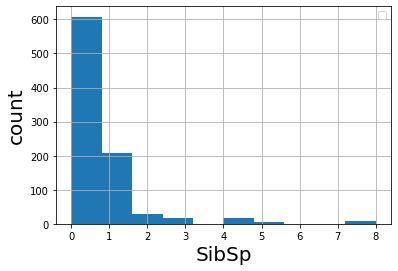

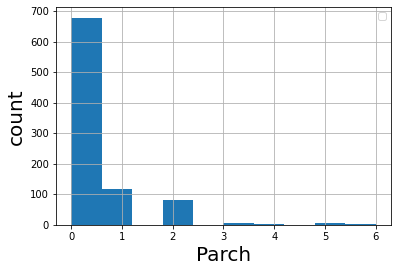

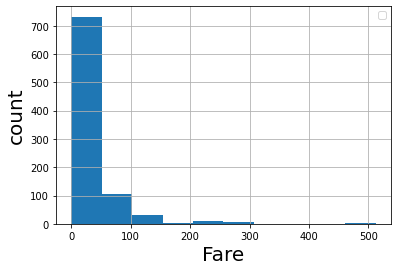

In [207]:
for col in numerical_col_series:
    title = col+"_hist"
    plt.xlabel(col, fontsize=20) #x軸ラベル
    plt.ylabel("count", fontsize=20)#y軸ラベル
    plt.grid(True)      # 目盛線の表示
    
    #plt.title(col, fontsize=20)  # タイトル
    #plt.hist(train[col],color = 'blue')
    plt.hist(train[col])
    fname = "1variable_numeric_"+col+"_hist.png"
    #凡例を表示させる最も簡単な方法
    ## plt.plot(x, y, label='label_name')
    ## plt.legend()
    plt.legend()
    plt.savefig(fname)
    plt.show()

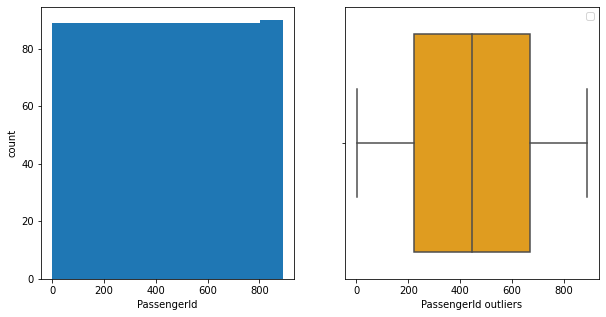

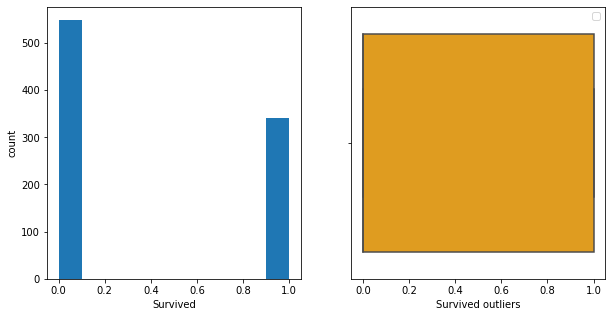

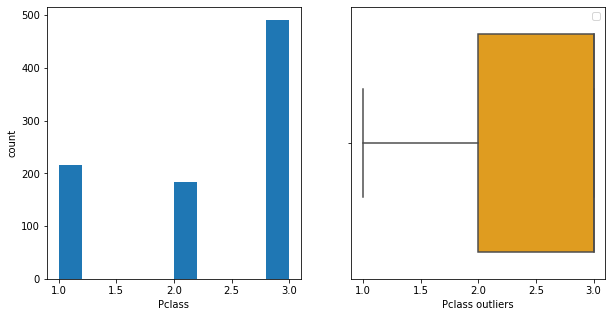

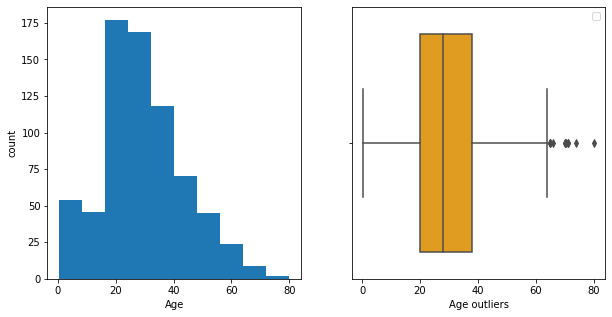

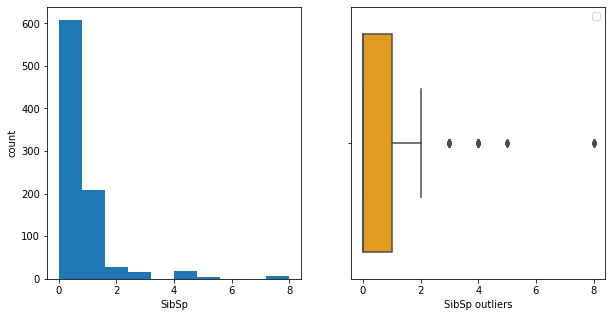

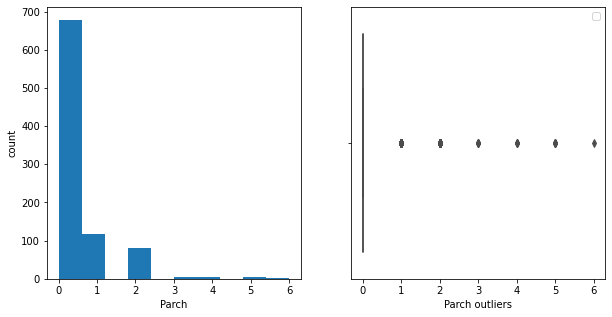

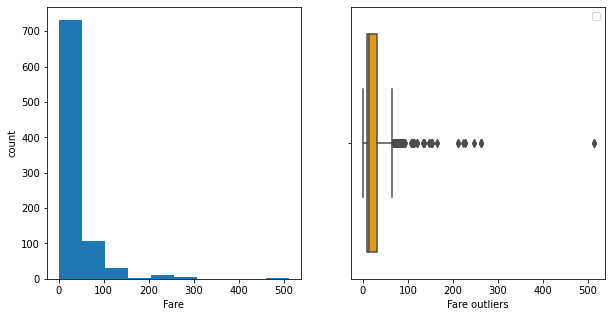

In [208]:
for col in numerical_col_series:
    #col = "Age"
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    
    #axes[0].hist(train[col],color = 'blue')
    axes[0].hist(train[col])
    axes[0].set_ylabel('count')
    axes[0].set_xlabel(col)
    axes[1] = sns.boxplot(data=train, x=col, color='orange')
    x_label = col + " outliers"
    axes[1].set_xlabel(x_label)
    plt.legend()
    fname = "1variable_numeric_"+col+"_hist_box.png"
    plt.savefig(fname)
    plt.show()

対数変換
https://best-biostatistics.com/summary/log-transformed.html#:~:text=%E5%AF%BE%E6%95%B0%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%E3%81%AE%E3%83%87%E3%83%BC%E3%82%BF,%E3%81%8C%E9%87%8D%E8%A6%81%E3%81%AA%E7%90%86%E7%94%B1%E3%81%A7%E3%81%99%E3%80%82


統計学で対数変換が必要になるのでしょうか？

対数変換が統計学においても重要になるのは、対数変換すると正規分布になる、対数正規分布が存在するからです。

そして正規分布に変換できると、あとはこれまで見てきた正規分布に用いることができる様々な手法（パラメトリックな手法）を用いることができるので、非常に便利です。

定義上、値が0の場合は、対数をとることができません。

つまり、ゼロを含むデータでは対数変換を行うことはできません。

ではどうすれば良いのでしょうか？

それはデータの値全てに1を足すです。

■他の効果：

極端な数値の効果を低減する

もしデータに極端に大きい・小さい数値が含まれていても、その影響を軽減できるという効果もある。たとえばlog(100)は4.60517で、log(10000)は9.21034になる。

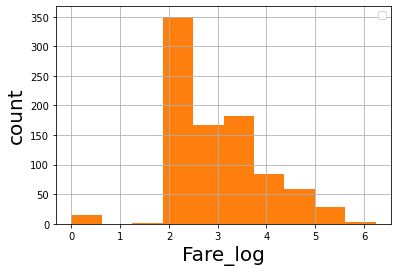

In [62]:
train["Fare_log"] = np.log(train['Fare']+1)
plt.hist(train["Fare_log"])
col = "Fare_log"
title = col+"_hist"
plt.xlabel(col, fontsize=20) #x軸ラベル
plt.ylabel("count", fontsize=20)#y軸ラベル
plt.grid(True)      # 目盛線の表示

#plt.title(col, fontsize=20)  # タイトル
#plt.hist(train[col],color = 'blue')
plt.hist(train[col])
fname = "1variable_numeric_"+col+"_hist.png"
plt.legend()
plt.savefig(fname)
plt.show()

In [185]:
import glob
import zipfile

glob.glob("./1variable_*.png")

['./1variable_numeric_Pclass_hist.png',
 './1variable_numeric_Fare_hist_box.png',
 './1variable_numeric_PassengerId_hist.png',
 './1variable_category_Embarked_hist.png',
 './1variable_numeric_Survived_hist_box.png',
 './1variable_numeric_Age_hist_box.png',
 './1variable_category_Sex_hist.png',
 './1variable_numeric_SibSp_hist.png',
 './1variable_category_Ticket_hist.png',
 './1variable_numeric_Fare_hist.png',
 './1variable_category_Name_hist.png',
 './1variable_numeric_Survived_hist.png',
 './1variable_numeric_Age_hist.png',
 './1variable_numeric_PassengerId_hist_box.png',
 './1variable_numeric_SibSp_hist_box.png',
 './1variable_numeric_Parch_hist.png',
 './1variable_category_Cabin_hist.png',
 './1variable_numeric_Parch_hist_box.png',
 './1variable_numeric_Pclass_hist_box.png']

In [189]:
import glob
import zipfile

targets = []

for f in sorted(glob.glob("./1variable_*.png")):
    targets.append(f)

targets


compFile01 = zipfile.ZipFile('1variable_.zip', 'w')
for y in targets:
  compFile01.write(y)
compFile01.close()


# 2変数

### Pattern1 質的データ × 質的データ

In [49]:
str_col_series

3         Name
4          Sex
8       Ticket
10       Cabin
11    Embarked
Name: カラム名, dtype: object

In [57]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train['Deck'] = train['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

dic['Deck'] = "Cabin（部屋番号）の頭文字"

col_info_summary = iput_data_summary(data_df=train, header_info_dic=dic)

col_info_summary

,カラム名,カラム概要,レコード数,ユニーク数,欠損(null)数,欠損率,データ型
0,PassengerId,乗客のユニークID,891,891,0,0.000,int64
1,Survived,"乗客の生死. 0 = 死亡, 1 = 生存",891,2,0,0.000,int64
2,Pclass,チケットのクラス. 1等席~3等席,891,3,0,0.000,int64
3,Name,乗客名,891,891,0,0.000,object
4,Sex,性別.male or female,891,2,0,0.000,object
5,Age,年齢,891,89,177,0.199,float64
6,SibSp,同乗の兄弟姉妹、配偶者の人数,891,7,0,0.000,int64
7,Parch,同乗の親、子供の人数,891,7,0,0.000,int64
8,Ticket,チケット番号,891,681,0,0.000,object
9,Fare,乗船料,891,248,0,0.000,float64


In [9]:
train = train.drop("Cabin",axis=1)

In [10]:
str_col = col_info_summary[col_info_summary["データ型"]=="object"]
str_col_series = str_col["カラム名"]
str_col_series

3         Name
4          Sex
8       Ticket
10       Cabin
11    Embarked
Name: カラム名, dtype: object

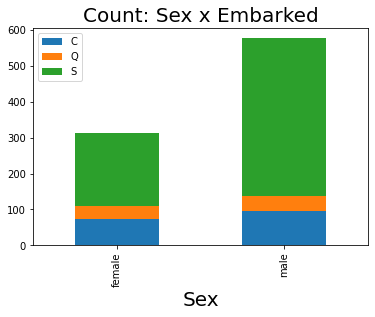

In [12]:
str_col_series


import itertools

target_str_col_series = str_col_series.drop([3,8,10])

for pair in itertools.combinations(target_str_col_series, 2):
    #print(pair)
    #print(pair[0])
    #print(pair[1])
    crossed = pd.crosstab(train[pair[0]],train[pair[1]])
    #print(crossed)
    ## stacked=Trueで積み上げ機能オン
    crossed.plot.bar(stacked=True)
    #title = "Frequency: " + pair[0] + " x " + pair[1]
    title = "Count: " + pair[0] + " x " + pair[1]
    plt.title(title, fontsize=20)  # タイトル
    plt.xlabel(pair[0], fontsize=20) #x軸ラベル
    plt.legend()
    fname="2variable_category_crosstab_" +pair[0] + "_" + pair[1]+".png"
    plt.savefig(fname)
    plt.show()
    

In [24]:
import glob
import zipfile

glob_key = "./2variable_*.png"
zipfile_name = "2variable_.zip"

def zip_glog_key_file(glob_key,zipfile_name):
    targets = []

    for f in sorted(glob.glob(glob_key)):
        targets.append(f)

    targets


    compFile01 = zipfile.ZipFile(zipfile_name, 'w')
    for y in targets:
      compFile01.write(y)
    compFile01.close()


zip_glog_key_file(glob_key,zipfile_name)

### Pattern2 質的データ × 量的データ

In [104]:
target_cols = pd.concat([numerical_col_series, target_str_col_series])
target_cols

0     PassengerId
1        Survived
2          Pclass
5             Age
6           SibSp
7           Parch
9            Fare
4             Sex
11       Embarked
13           Deck
dtype: object

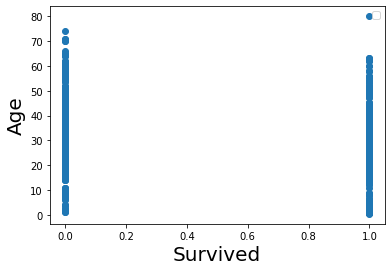

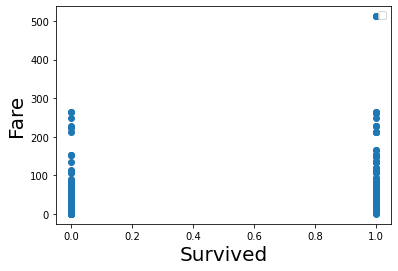

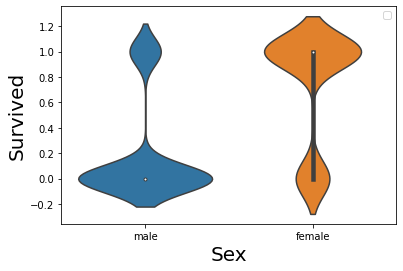

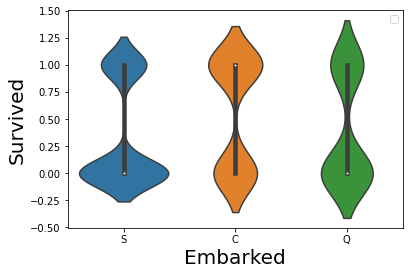

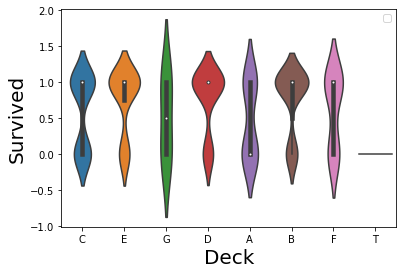

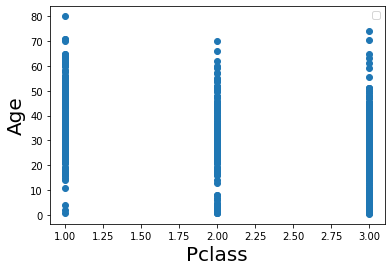

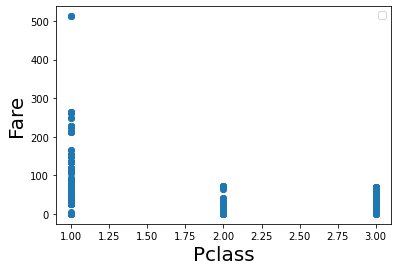

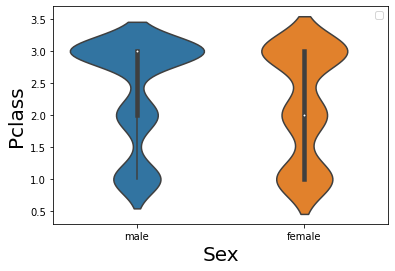

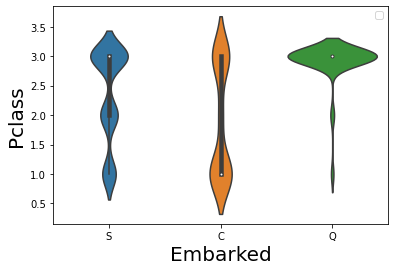

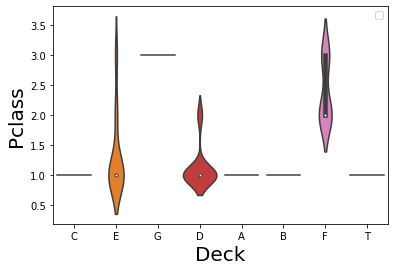

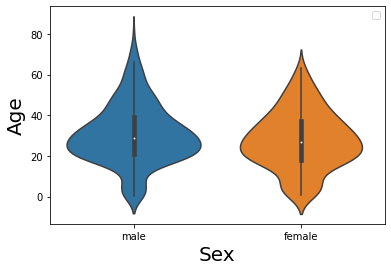

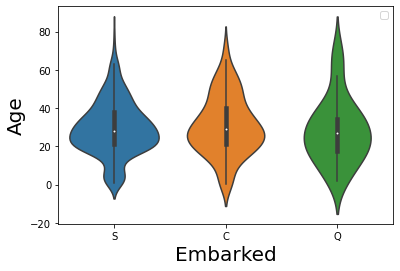

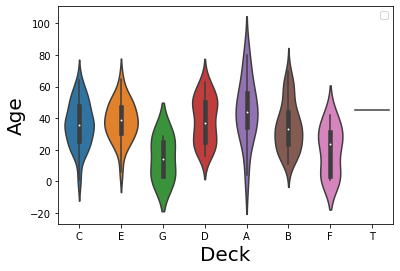

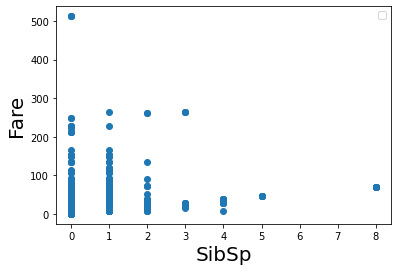

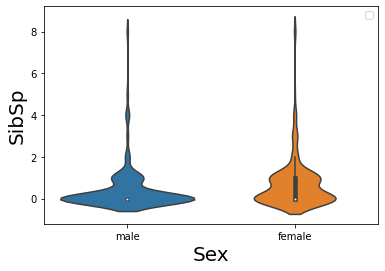

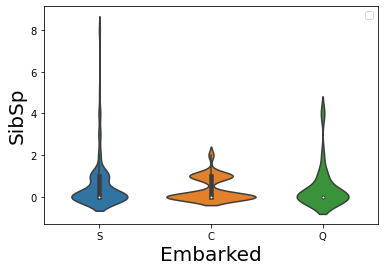

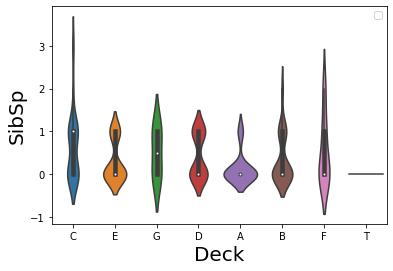

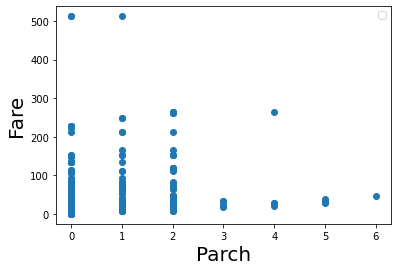

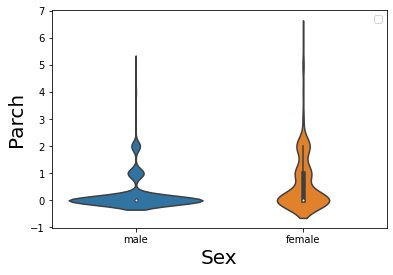

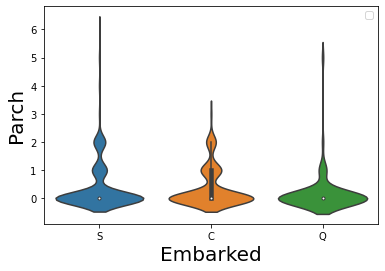

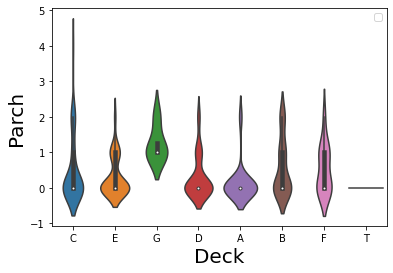

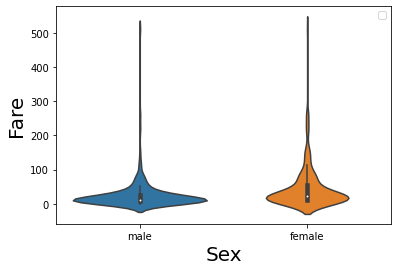

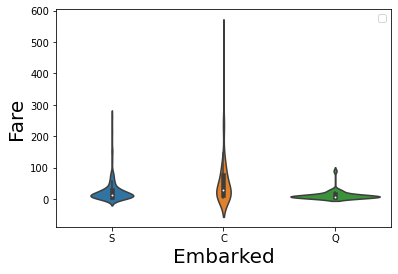

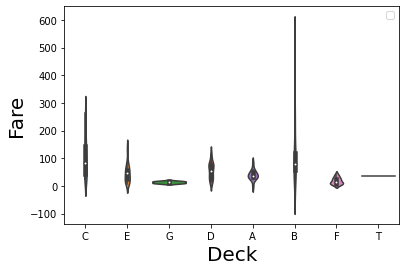

In [129]:
# Pattern2 質的データ × 量的データ

for pair in itertools.combinations(target_cols.drop(0), 2):
    df = col_info_summary[col_info_summary["カラム名"] == pair[0]]
    pair0_dtype = list(df["データ型"])
    
    df = col_info_summary[col_info_summary["カラム名"] == pair[1]]
    pair1_dtype = list(df["データ型"])
    
    #print(pair)
    #print("--",pair0_dtype[0])
    #print("--",pair1_dtype[0])
    if pair0_dtype[0] == pair1_dtype[0]:
        #print("-- same type")
        continue
    elif pair0_dtype[0] == "int64" and  pair1_dtype[0] == "float64":
        #print("-- int and float")
        # Pattern3 量的データ × 量的データ
        '''
        plt.scatter(train[pair[0]] ,train[pair[1]])
        plt.xlabel(pair[0], fontsize=20) #x軸ラベル
        plt.ylabel(pair[1], fontsize=20)#y軸ラベル
        plt.legend()
        #fname="vioplot_" +pair[0] + "_" + pair[1]+".png"
        #plt.savefig(fname)
        plt.show()
        '''
        continue
    elif pair1_dtype[0] == "int64" and  pair0_dtype[0] == "float64":
        #print("-- float and int")
        continue
    else : #Pattern3 質的データ × 量的データ
        #print("-- different type")
        #boxplot or violinplot
        #sns.boxplot(data=train,x="Survived",y='Age')
        if pair0_dtype[0] == "object":
            sns.violinplot(data=train,x=pair[0],y=pair[1])
            plt.xlabel(pair[0], fontsize=20) #x軸ラベル
            plt.ylabel(pair[1], fontsize=20)#y軸ラベル
        else:
            sns.violinplot(data=train,x=pair[1],y=pair[0])
            plt.xlabel(pair[1], fontsize=20) #x軸ラベル
            plt.ylabel(pair[0], fontsize=20)#y軸ラベル
        
        plt.legend()
        fname="vioplot_" +pair[0] + "_" + pair[1]+".png"
        plt.savefig(fname)
        plt.show()
        

### Pattern3 量的データ × 量的データ

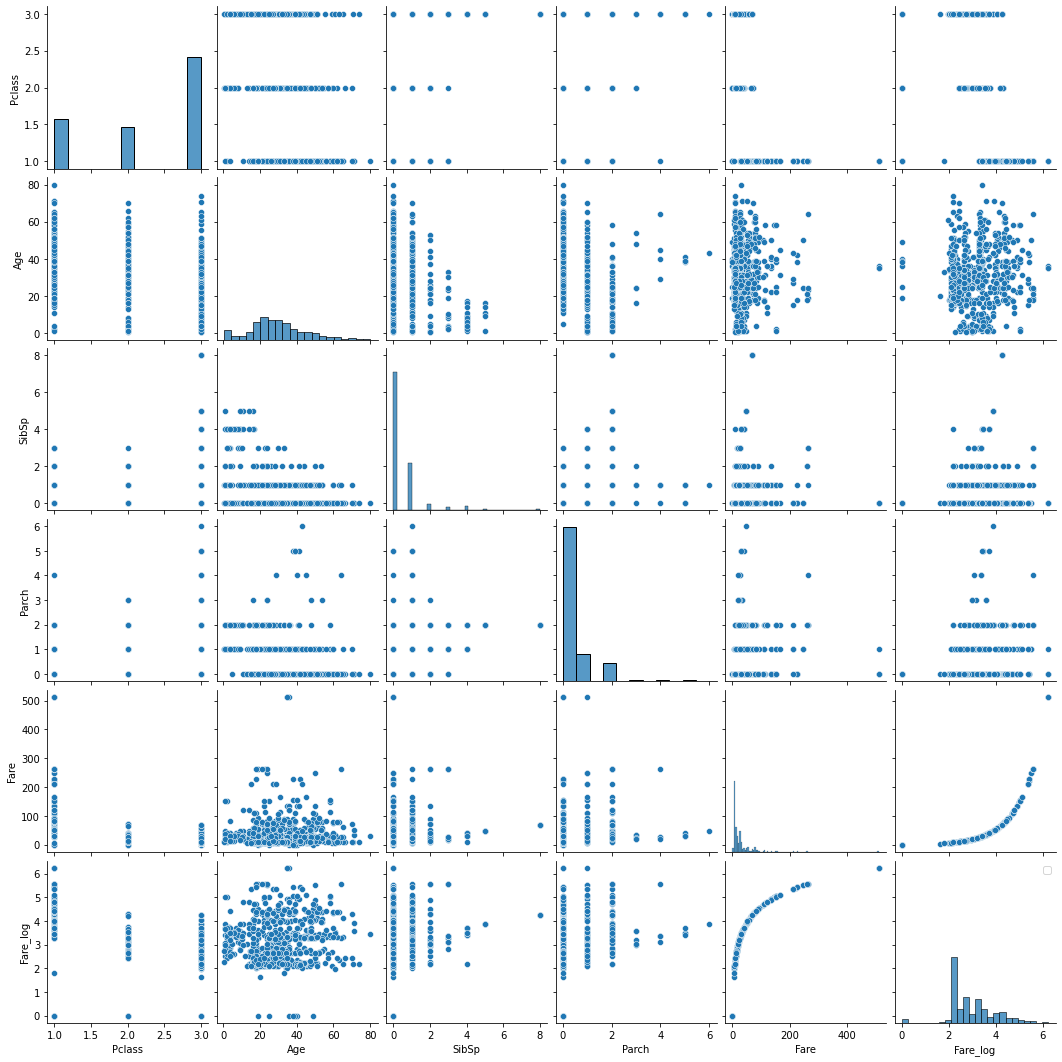

In [67]:
sns.pairplot(train.drop(["PassengerId","Survived"],axis=1).select_dtypes(include=[int,float]))

#plt.title("numeric_scatterplot_matrix", fontsize=20)  # タイトル
plt.xlabel(pair[0], fontsize=50) #x軸ラベル
plt.legend()
fname="numeric_scatterplot_matrix.png"
plt.savefig(fname)
plt.show() 

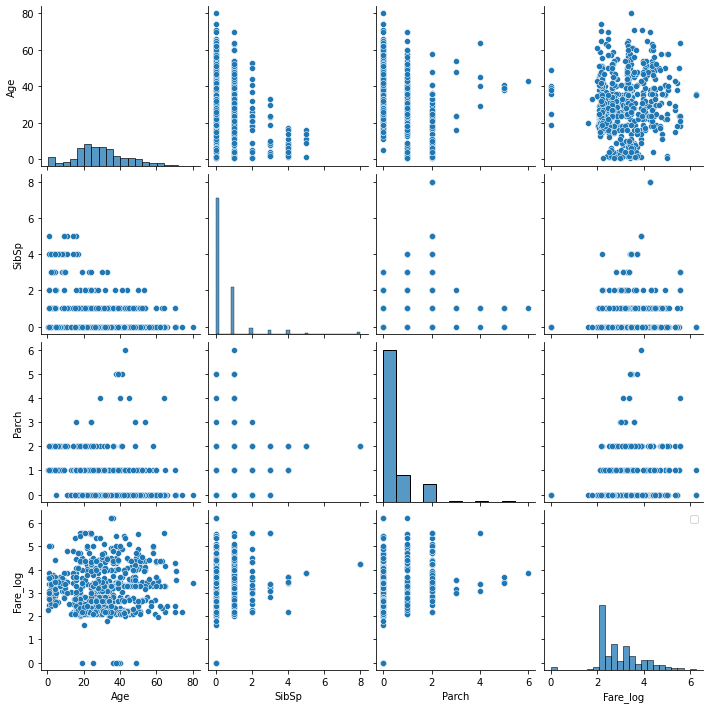

In [70]:
sns.pairplot(train.drop(["PassengerId","Survived","Pclass","Fare"],axis=1).select_dtypes(include=[int,float]))
plt.xlabel(pair[0], fontsize=50) #x軸ラベル
plt.legend()
fname="numeric_scatterplot_matrix.png"
plt.savefig(fname)
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Fare'>

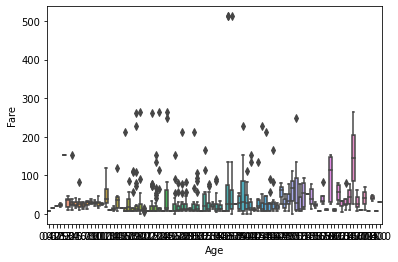

In [10]:
sns.boxplot(data=train,x="Age",y="Fare") #非推奨：見てもよくわからい

### 2変数：目的変数×その他(質的)

In [17]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train['Deck'] = train['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

train["Survived"]=train["Survived"].astype("str")
train.dtypes

PassengerId      int64
Survived        object
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Deck            object
dtype: object

In [25]:
dic['Deck'] = "Cabin（部屋番号）の頭文字"
col_info_summary = iput_data_summary(data_df=train, header_info_dic=dic)

#col_info_summary
str_col = col_info_summary[col_info_summary["データ型"]=="object"]
str_col_series = str_col["カラム名"]
str_col_series

1     Survived
3         Name
4          Sex
8       Ticket
10       Cabin
11    Embarked
12        Deck
Name: カラム名, dtype: object

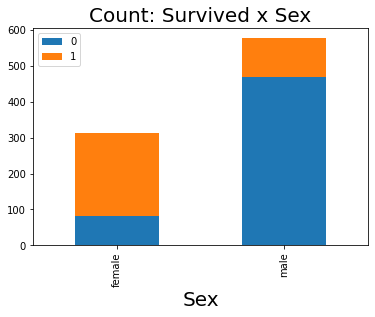

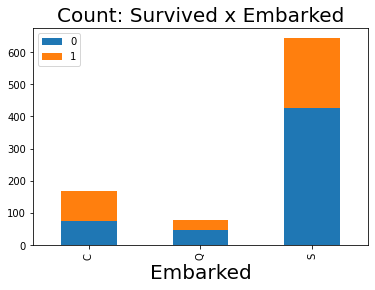

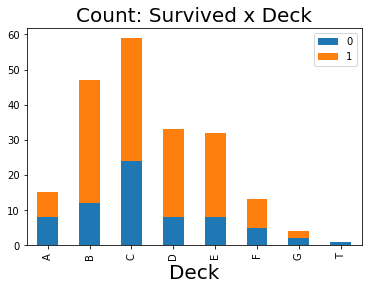

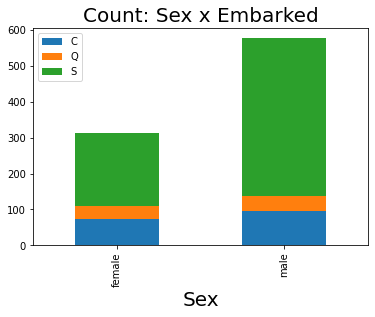

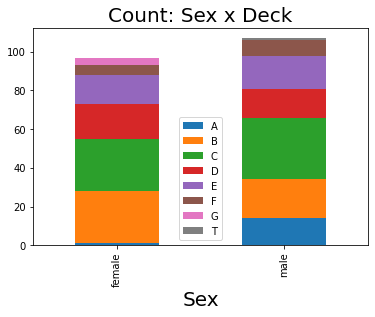

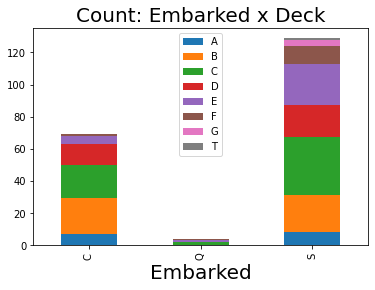

In [53]:
target_str_col_series = str_col_series.drop([3,8,10])

'''
graph = plt.bar(left, height)
def autolabel(graph):
    for rect in graph:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')
graph = crossed.plot.bar(stacked=True)
autolabel(graph)
'''

for pair in itertools.combinations(target_str_col_series, 2):
    #print(pair)
    #print(pair[0])
    #print(pair[1])
    if pair[0] == target_col:
        crossed = pd.crosstab(train[pair[1]],train[pair[0]])
        crossed.plot.bar(stacked=True)
        plt.xlabel(pair[1], fontsize=20) #x軸ラベル
        
    else:
        crossed = pd.crosstab(train[pair[0]],train[pair[1]])
        crossed.plot.bar(stacked=True)
        plt.xlabel(pair[0], fontsize=20) #x軸ラベル
    
    #title = "Frequency: " + pair[0] + " x " + pair[1]
    title = "Count: " + pair[0] + " x " + pair[1]
    plt.title(title, fontsize=20)  # タイトル
    
    plt.legend()
    fname="2variable_category_crosstab_" +pair[0] + "_" + pair[1]+".png"
    plt.savefig(fname)
    plt.show()

In [46]:
!pip install tabulate

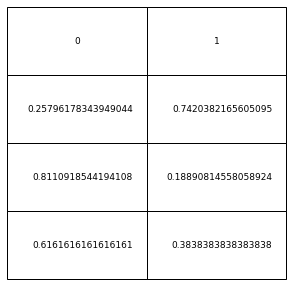

In [45]:
#crossed = pd.crosstab(train["Sex"],train["Survived"],margins=True,normalize='all')
crossed = pd.crosstab(train["Sex"],train["Survived"],margins=True,normalize='index')


def df_to_save_png(df,w,h,outputPath):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.table(
        df.values,
        colLabels = df.columns,
        loc = 'center',
        bbox=[0,0,1,1]
    )
    plt.savefig(outputPath)
    plt.show()

df_to_save_png(crossed,5,5,"Sex-Survived-crossed.png")

In [47]:
crossed.to_markdown()

'| Sex    |        0 |        1 |\n|:-------|---------:|---------:|\n| female | 0.257962 | 0.742038 |\n| male   | 0.811092 | 0.188908 |\n| All    | 0.616162 | 0.383838 |'

In [50]:
crossed

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


### 2変数：目的変数×その他(量的)

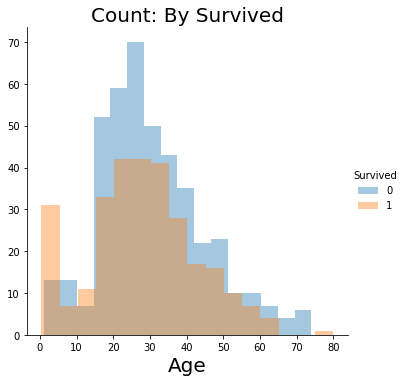

In [65]:
g=sns.FacetGrid(train,hue="Survived",height=5)
g.map(sns.distplot,"Age",kde=False)
g.add_legend()
plt.title("Count: By Survived", fontsize=20)  # タイトル
plt.xlabel("Age", fontsize=20) #x軸ラベル

plt.savefig('Survived_Age_factgrid.png')

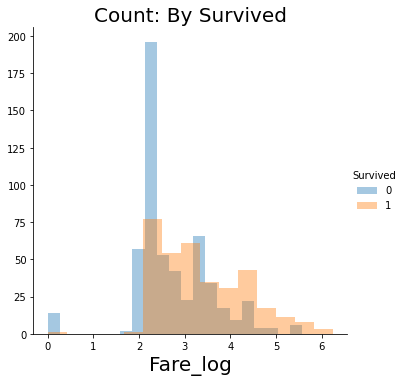

In [66]:
g=sns.FacetGrid(train,hue="Survived",height=5)
g.map(sns.distplot,"Fare_log",kde=False)
g.add_legend()
plt.title("Count: By Survived", fontsize=20)  # タイトル
plt.xlabel("Fare_log", fontsize=20) #x軸ラベル

plt.savefig('Survived_Fare_log_factgrid.png')

# 3変数

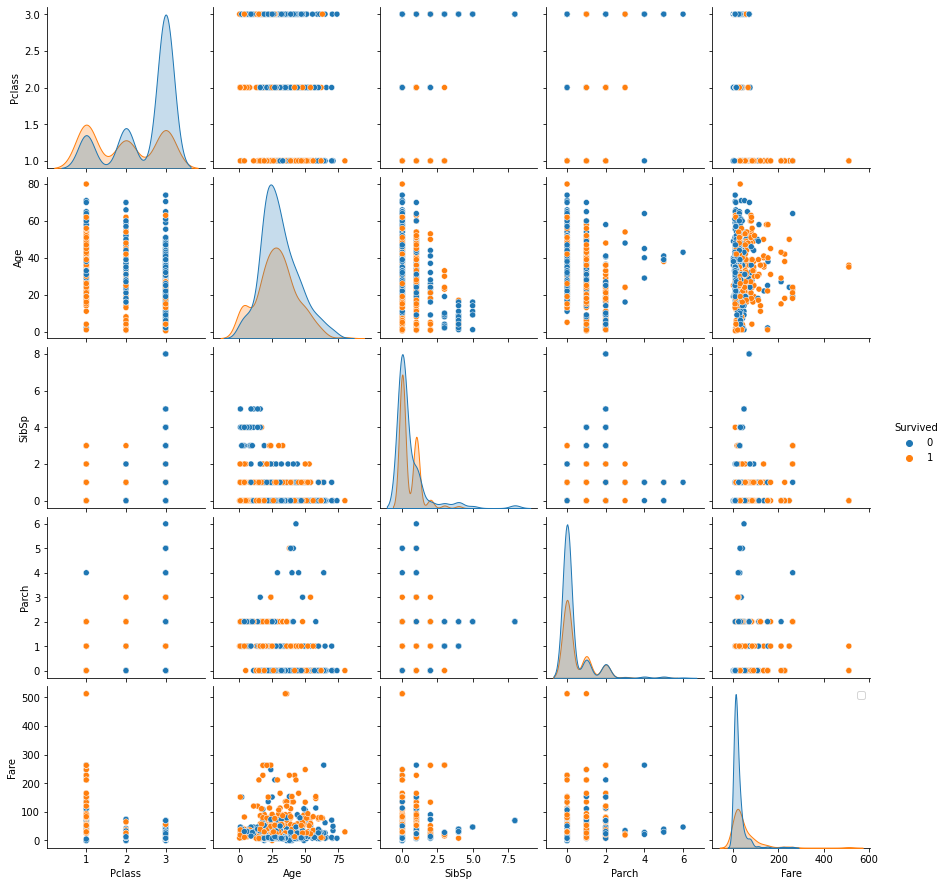

In [231]:
# (量的データ×量的データ):散布図  × 質的データ
sns.pairplot(train.drop("PassengerId",axis=1).select_dtypes(include=[int,float]), hue = target_col)
plt.xlabel(pair[0], fontsize=50) #x軸ラベル
plt.legend()
fname="numeric_scatterplot_matrix_hue_target_col.png"
plt.savefig(fname)
plt.show() 

In [7]:
# (質的データ×質的データ)  × 質的データ
# 3次元を2次元にする?

train["Deck"] = train["Cabin"].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

train["Sex-Deck"] = train["Sex"]+"-"+train["Deck"]

crossed = pd.crosstab(train["Sex-Deck"],train["Survived"])
crossed


Survived,0,1
Sex-Deck,,
female-A,0,1
female-B,0,27
female-C,3,24
female-D,0,18
female-E,1,14
female-F,0,5
female-G,2,2
male-A,8,6
male-B,12,8


<AxesSubplot:xlabel='Sex-Deck'>

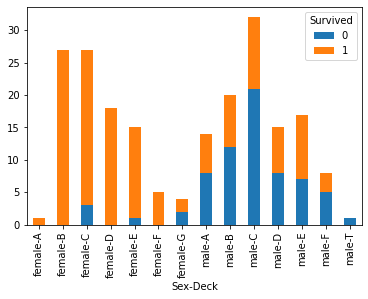

In [8]:
## stacked=Trueで積み上げ機能オン
crossed.plot.bar(stacked=True)

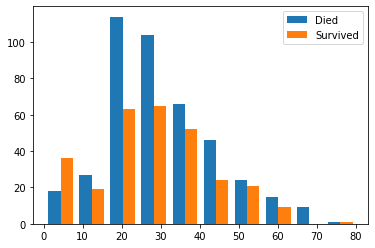

In [109]:
plt.hist([train[train['Survived']==0].Age, train[train['Survived']==1].Age], label=['Died', 'Survived'])

plt.legend()